# Milestone P4 - Creative extension

In [1]:
#import libraries to use dataframes
import pandas as pd
import numpy as np

#we use sklearn for the logistic regression learning algorithm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance


#import the data
DATA_FOLDER = 'data/'
DATASET = DATA_FOLDER+"SambnisImp.csv"

DATASET_TERROR = DATA_FOLDER+"globalterrorismdb_0919dist.xlsx"
DATASET_CID = DATA_FOLDER+"Sambanis_cid.dta"

#Opening and loading of files
df = pd.read_csv(DATASET, error_bad_lines=False, warn_bad_lines=True)

In [2]:
df_t = pd.read_excel(DATASET_TERROR, error_bad_lines=False, warn_bad_lines=True)
df_t = df_t.set_index('eventid')

In [5]:
#Reduction of the CWD to 91 variables + years + cow code
doc = df[["warstds", "year", "cowcode", "ager", "agexp", "anoc", "army85", "autch98", "auto4",
    "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
    "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel", "durable",
    "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590", "expgdp", "exrec",
    "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2", "geo34", "geo57",
    "geo69", "geo8", "illiteracy", "incumb", "infant", "inst", "inst3", "life",
    "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper", "mirps0",
    "mirps1", "mirps2", "mirps3", "nat_war", "ncontig", "nmgdp", "nmdp4_alt",
    "numlang", "nwstate", "oil", "p4mchg", "parcomp", "parreg", "part",
    "partfree", "plural", "plurrel", "pol4", "pol4m", "pol4sq", "polch98",
    "polcomp", "popdense", "presi", "pri", "proxregc", "ptime", "reg",
    "regd4_alt", "relfrac", "seceduc", "second", "semipol3", "sip2", "sxpnew",
    "sxpsq", "tnatwar", "trade", "warhist", "xconst"]]

In [3]:
#-------------TODO--------------#
#Replace country id in civil war dataset with proper names
country_id = pd.read_stata(DATASET_CID)
country_id.head()
#-------------------------------#



'''# Get a list of country and their code (index) for the terrorism dataset
df_t.head()
country = df_t[["country", "country_txt"]]
maxval = df_t['country'].max()
print(maxval)
lst=[]
for i in range(maxval):
    temp = country[country.country == i]
    if(not temp.empty):
        temp1=country[country.country == i].iloc[0]
        lst.append(temp1.country_txt)
    else:
        #not a country
        lst.append("NAC")
countrylist = pd.DataFrame(lst)
countrylist.shape   
'''
#load the cowcode dataframe
cow = pd.read_csv('data/COW country codes.csv')
#dropuseless column and change names of the 2 remaining
cow=cow.drop(['StateAbb'],axis=1)
cow.columns = ['cowcode','StateName']
#merge it to doc (into new) that now have a column 'StateName' matching cow code
new = doc.merge(cow)
new.head()

1004


(1004, 1)

In [4]:
#Calculate number of terrorist attacks in each country for each year. Final dataframe is fy1 which contains all years from
#1970 to 2000 with all countries and their number of terrorist attacks
#new = df_t[(df_t.country == 200)]
#new.head()
import sys
first = df_t[df_t['iyear']==1970]
#nb = len(df_t[(df_t.iyear==1970 & df_t.country == 200)])
fc = first[first['country']==200]
maxval = df_t['country'].max()
print(maxval)
fy = np.arange(1970, 2000, 1)
fy1 = pd.DataFrame(fy)
fy1 = fy1.set_index(0)
#length = len(df_t[(df_t.country==1)])
#print(length)
for i in range(maxval):
    ls=[]
    for j in range(1970,2000):
        temp = df_t[(df_t.country==i)]
        temp2 = len(temp[(temp.iyear==j)])
        ls.append(temp2)
    fy1[i] = ls
    
fy1.columns = [countrylist[0]]
fy1.drop(list(fy1.filter(regex = 'NAC')), axis = 1, inplace = True)
fy1.head()

1004


,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,International,South Vietnam,East Germany (GDR),New Hebrides,United Kingdom,Zaire,People's Republic of the Congo,Serbia,Montenegro,Kosovo
0,,,,,,,,,,,,,,,,,,,,,
1970,0,0,0,0,0,0,21,0,1,0,...,0,0,12,0,12,0,0,0,0,0
1971,0,0,0,0,0,0,7,0,1,0,...,0,0,4,0,81,0,0,0,0,0
1972,0,0,1,0,0,0,20,0,8,7,...,0,1,0,0,292,3,1,0,0,0
1973,1,0,0,0,0,0,60,0,0,2,...,0,0,0,0,189,1,0,0,0,0
1974,0,0,0,1,0,0,71,0,1,1,...,0,0,1,0,203,0,0,0,0,0


In [6]:
#Creating dataframes according to the parameters that were taken into account by the different papers

#Fearon and Laitin (2003)
df2003 = doc [["warhist", "ln_gdpen", "lpopns", "lmtnest",
    "ncontig", "oil", "nwstate", "inst3", "pol4", "ef", "relfrac"]]

#Collier and Hoeffler (2004)
df2004 = doc[["sxpnew", "sxpsq", "ln_gdpen", "gdpgrowth",
    "warhist", "lmtnest", "ef", "popdense", "lpopns", "coldwar", "seceduc",
    "ptime"]]

#Hegre and Sambanis (2006)
df2006 = doc[["lpopns", "ln_gdpen", "inst3", "parreg", "geo34",
    "proxregc", "gdpgrowth", "anoc", "partfree", "nat_war", "lmtnest",
    "decade1", "pol4sq", "nwstate", "regd4_alt", "etdo4590", "milper", "geo1",
    "tnatwar", "presi"]]

In [7]:
#Setting the y parameter wich is the occurence of a civil war => warstds
#This parameter is the same for all curves even for the penalized LR
y = doc["warstds"]

In [8]:
#Uncorrected Logistic regression with the parameters solver and max_iter because the number of iterations were not enough
#Fearon and Laitin (2003)
log2003 = LogisticRegression(penalty = 'none', solver='lbfgs', max_iter=1e9).fit(df2003,y)

#Collier and Hoeffler (2004)
log2004 = LogisticRegression(penalty = 'none', solver='lbfgs', max_iter=1e9).fit(df2004,y)

#Hegre and Sambanis (2006)
log2006 = LogisticRegression(penalty = 'none', solver='lbfgs', max_iter=1e9).fit(df2006,y)

In [9]:
#Calculations of the estimates and the AUC score
#Fearon and Laitin (2003)
probs = log2003.predict_proba(df2003)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)

#Collier and Hoeffler (2004)
probs4 = log2004.predict_proba(df2004)
preds4 = probs4[:,1]
fpr4, tpr4, threshold4 = metrics.roc_curve(y, preds4)
roc_auc4 = metrics.auc(fpr4, tpr4)

#Hegre and Sambanis (2006)
probs6 = log2006.predict_proba(df2006)
preds6 = probs6[:,1]
fpr6, tpr6, threshold6 = metrics.roc_curve(y, preds6)
roc_auc6 = metrics.auc(fpr6, tpr6)

In [10]:
#Function that will split a dataframe into a training set and a testing set according to the ratio
#I chose the ratio of 2/3 because this what they said they used in the paper
def split_set(data_to_split, ratio=2/3):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask].reset_index(drop=True), data_to_split[~mask].reset_index(drop=True)]

In [11]:
#Splitting of the training set and testing set, Creation of the y training and y testing
#Removing of the "warstds" which is the variable we want to predict so it should be erased from the X training and X testing
training_set, testing_set = split_set(doc)
y_train = training_set["warstds"]
training_set.drop("warstds",axis='columns', inplace=True)
y_test = testing_set["warstds"]
testing_set.drop("warstds",axis='columns', inplace=True)

In [12]:
#Creation of a Random Forest classifier with max_depth = 10, otherwise the ROC plot look weird
clf = RandomForestClassifier(n_estimators=100, max_depth=10)

In [13]:
#Fitting the model with the training set
clf.fit(training_set, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [14]:
#Predictions with the testing set, calculations of the AUC scores
probs0c = clf.predict_proba(testing_set)
preds0c = probs0c[:,1]
fpr0c, tpr0c, threshold0c = metrics.roc_curve(y_test, preds0c)
roc_auc0c = metrics.auc(fpr0c, tpr0c)

In [15]:
boostclf = GradientBoostingClassifier(n_estimators=100, max_depth=10)

In [16]:
boostclf.fit(training_set, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [17]:
#Predictions with the testing set, calculations of the AUC scores
probs0bc = boostclf.predict_proba(testing_set)
preds0bc = probs0bc[:,1]
fpr0bc, tpr0bc, threshold0bc = metrics.roc_curve(y_test, preds0bc)
roc_auc0bc = metrics.auc(fpr0bc, tpr0bc)

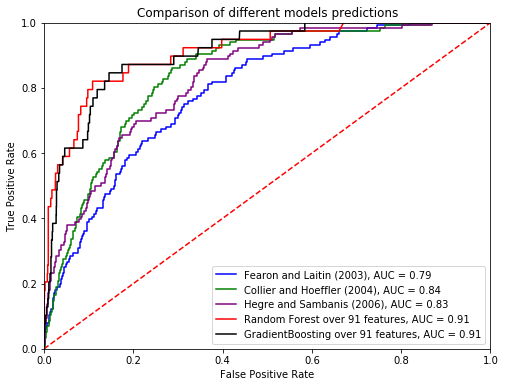

In [18]:
#Plotting of the curves with a red dashed line like in ROC plots
plt.figure(figsize = (8,6))
plt.title('Comparison of different models predictions')
plt.plot(fpr, tpr, 'b', label = 'Fearon and Laitin (2003), '+'AUC = ' + '{:.2f}'.format(roc_auc)) 
plt.plot(fpr4, tpr4, 'green', label = 'Collier and Hoeffler (2004), '+'AUC = ' + '{:.2f}'.format( roc_auc4))
plt.plot(fpr6, tpr6, 'purple', label = 'Hegre and Sambanis (2006), '+'AUC = ' + '{:.2f}'.format( roc_auc6)) 
plt.plot(fpr0c, tpr0c, 'red', label = 'Random Forest over 91 features, '+'AUC = ' + '{:.2f}'.format( roc_auc0c))
plt.plot(fpr0bc, tpr0bc, 'black', label = 'GradientBoosting over 91 features, '+'AUC = ' + '{:.2f}'.format( roc_auc0bc))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

2000

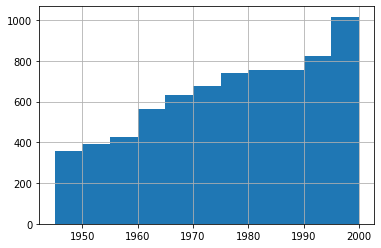

In [19]:
#Histogram to see the repartition of the values accross the years
#We see that there are twice as many variables in the 1990-2000 than in 1950-1960
doc['year'].hist(bins=11)
doc['year'].max()

In [20]:
#Dividing the Dataset according to a number of years 
period = 10
vecy=np.arange(1945,2000,period)
tab = []
for year in vecy:
    tab.append( doc[ (doc['year'] >= year) & (doc['year'] < year+period) ] )
tab.append(doc[ doc['year'] >= 2000-55%period ])

In [21]:
#tab

In [22]:
#Test of a RandomForestClassifier
def testRF( X , y , percent=0.25 ):

    clf = RandomForestClassifier(n_estimators=100)
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=percent)
    clf.fit(X_train,y_train)
    predictions = clf.predict_proba(X_test)[:,-1]
    n=0
    for i in range(len(predictions)):
        tmp= int(predictions[i]*2)-y_train[i]
        if(tmp!=0): 
            n+=1 
            
    return n/len(predictions)

def testLR( X , y , percent=0.25 ):
    lr = LogisticRegression( penalty = 'none', solver='lbfgs', max_iter=1e9)
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=percent)
    lr.fit(X_train,y_train)
    predictions = lr.predict_proba(X_test)[:,-1]
    n=0
    for i in range(len(predictions)):
        tmp= int(predictions[i]*2)-y_train[i]
        if(tmp!=0): 
            n+=1 
            
    return n/len(predictions)

def rocRF( X , y , percent=0.25 ):
    clf = RandomForestClassifier(n_estimators=100, max_depth = 10)
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=percent)
    clf.fit(X_train,y_train)
    predictions = clf.predict_proba(X_test)[:,-1]
    falseRate, trueRate, threshold = metrics.roc_curve(y_test, predictions)
    auc = metrics.auc(falseRate, trueRate)
    auc = round(auc, 3)
    return falseRate , trueRate, auc
    

In [23]:
#Remove the y-column, and the year-column because we have grouped the values by year and it is not used in the model in the paper
X = doc.drop(['warstds','year'] , axis='columns')
y = doc['warstds'].values

#BIDOUILLAGE ----------------
percentFalseRF = []
percentFalseLR = []

percentFalseRF.append(testRF(X,y,0.1))
percentFalseLR.append(testLR(X,y,0.1))

In [24]:
for i in tab:
    X = i.drop(['warstds','year'] , axis='columns')
    y = i['warstds'].values
    percentFalseRF.append(testRF(X,y,0.1))
    percentFalseLR.append(testLR(X,y,0.1))

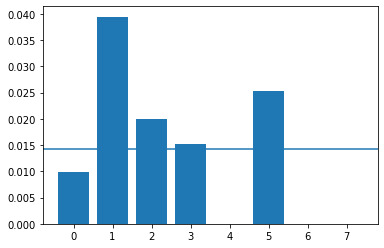

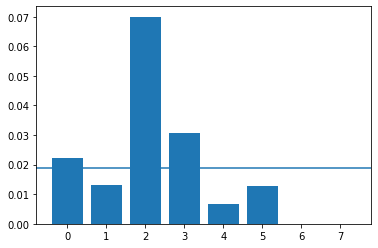

In [25]:
x= np.arange(0,len(percentFalseRF),1)

#random forest
plt.bar( x=x , height = percentFalseRF )
plt.axhline(y=np.mean(percentFalseRF[1:]))

#log reg
plt.figure()
plt.bar( x=x , height = percentFalseLR )
plt.axhline(y=np.mean(percentFalseLR[1:]))

0.767


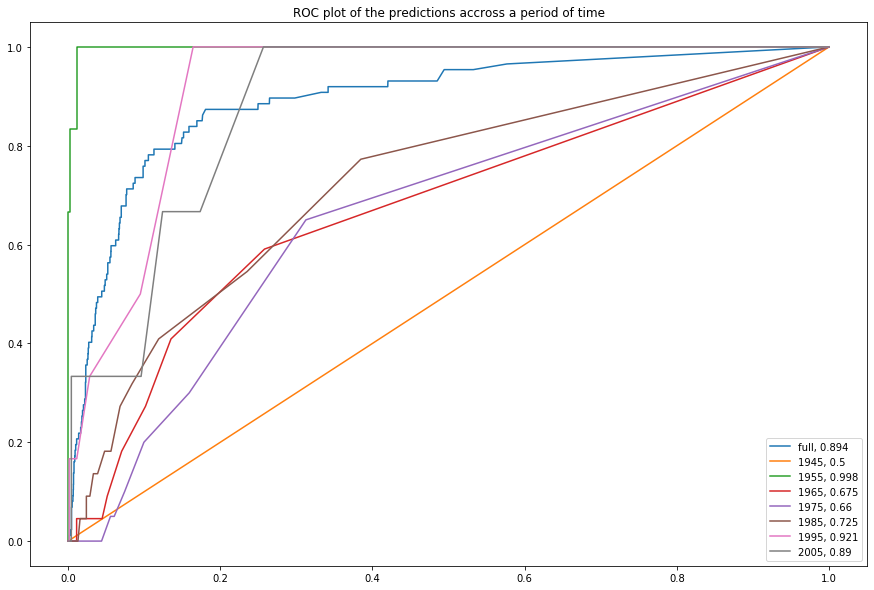

In [26]:
plt.figure(figsize=(15,10))

tabAUC=[]

X = doc.drop(['warstds','year'] , axis='columns')
y = doc['warstds'].values

falseRate , trueRate , auc = rocRF( X , y , 0.7  )
plt.plot(falseRate, trueRate, label = 'full, '+ str(auc))
tabAUC.append(auc)
year=1945
for i in tab:
    X = i.drop(['warstds','year'] , axis='columns')
    y = i['warstds'].values
    falseRate , trueRate , auc = rocRF( X , y , 0.7  )
    plt.plot(falseRate, trueRate, label = str(year) + ", "+ str(auc) )
    tabAUC.append(auc)
    year+=period
plt.title('ROC plot of the predictions accross a period of time')
plt.legend()

#print(tabAUC)
print(np.nanmean(tabAUC[1:]))

(0, 200)

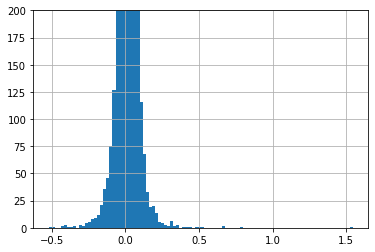

In [27]:
#Visualization of the repartition of the values according to GDP Growth
doc['gdpgrowth'].hist(bins=100)
plt.ylim([0,200])

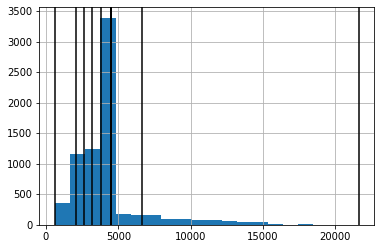

In [28]:
#Visualization of the repartition of the values according to GDP per capita
#We need to use quantiles
docbis = doc.copy()
doc['nmgdp'].hist(bins=20)
quantile = docbis['nmgdp'].quantile(np.arange(0,1.1,0.1))
for q in quantile:
    plt.axvline(x=q,color='k')

In [29]:
#Cutting by quantile
quantile = docbis['gdpgrowth'].quantile(np.arange(0,1.1,0.1))
tab=[]
for i in range(10):
    tab.append( doc[ (docbis['gdpgrowth'] >= quantile.iloc[i]) & (doc['gdpgrowth'] < quantile.iloc[i+1]) ] )

In [30]:
'''quantile = docbis['nmgdp'].quantile(np.arange(0,1.2,0.2))
tab=[]
for i in range(10):
    tab.append( doc[ (docbis['nmgdp'] >= quantile.iloc[i]) & (doc['nmgdp'] < quantile.iloc[i+1]) ] )'''

"quantile = docbis['nmgdp'].quantile(np.arange(0,1.2,0.2))\ntab=[]\nfor i in range(10):\n    tab.append( doc[ (docbis['nmgdp'] >= quantile.iloc[i]) & (doc['nmgdp'] < quantile.iloc[i+1]) ] )"

### GPD Growth

[0.737, 0.742, 0.879, 0.76, 0.5, 0.5, 0.728, 0.701, 0.689, 0.5]
0.6736000000000001


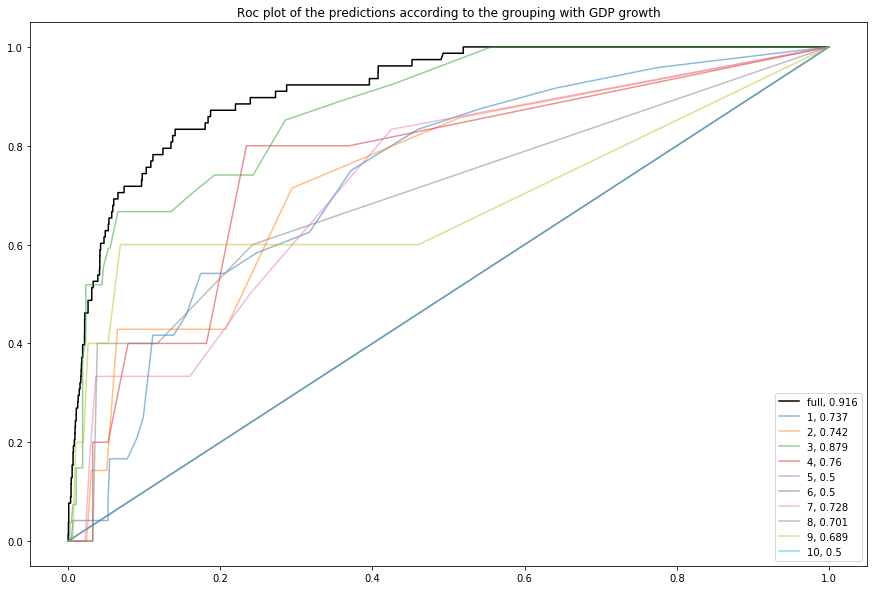

In [31]:
plt.figure(figsize=(15,10))

tabAUC=[]

X = doc.drop(['warstds','year','gdpgrowth'] , axis='columns')
y = doc['warstds'].values

falseRate , trueRate , auc = rocRF( X , y , 0.7  )
plt.plot(falseRate, trueRate, label = 'full, '+ str(auc) , color = 'k' )
tabAUC.append(auc)

qt=1

for df in tab:
    X = df.drop(['warstds','year'] , axis='columns')
    y = df['warstds'].values
    falseRate , trueRate , auc = rocRF( X , y , 0.7  )
    plt.plot(falseRate, trueRate, label = str(qt) + ", "+ str(auc) , alpha = 0.5)
    tabAUC.append(auc)
    qt+=1
    #print( df['gdpgrowth'].var() )
plt.title('Roc plot of the predictions according to the grouping with GDP growth')
plt.legend()

print(tabAUC[1:])
print(np.nanmean(tabAUC[1:]))

### GDP per capita

C:\anaconda\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


0.701
0.5786666666666667


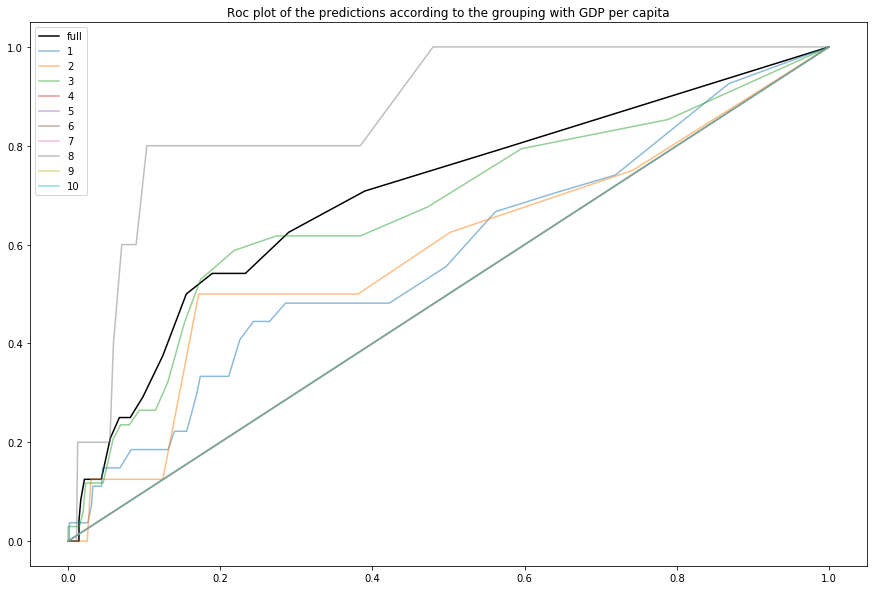

In [32]:
plt.figure(figsize=(15,10))

tabAUC=[]

doctmp = doc.sample(frac=0.2)

X = doctmp.drop(['warstds','year'] , axis='columns')
y = doctmp['warstds'].values

falseRate , trueRate , auc = rocRF( X , y , 0.9  )
plt.plot(falseRate, trueRate, label = 'full' , color = 'k' )
tabAUC.append(auc)

qt=1

for df in tab:
    X = df.drop(['warstds','year'] , axis='columns')
    y = df['warstds'].values
    falseRate , trueRate , auc = rocRF( X , y , 0.9  )
    plt.plot(falseRate, trueRate, label = qt , alpha = 0.5)
    tabAUC.append(auc)
    qt+=1
plt.title('Roc plot of the predictions according to the grouping with GDP per capita')
plt.legend()

print(tabAUC[0])
print(np.nanmean(tabAUC[1:]))

In [33]:
#test nmgdp == gdp per capita
cow = docFull['cowcode'].unique()

relative=[0]*len(docFull)
for country in cow:
    tmp = docFull[ docFull['cowcode']==country ].sort_values(by='year')
    for year in tmp['year'].unique()[1:]:
        before = tmp[ tmp['year'] == year-1 ]['nmgdp'].values[0]
        after = tmp[ tmp['year'] == year ]['nmgdp'].values[0]
        ratio = (after-before)/before 
        ind=docFull.loc[ (docFull['year'] == year) & (docFull['cowcode'] == country) ].index.values[0] 
        relative[ind]=ratio
docFull['evolnmgdp'] = relative

NameError: name 'docFull' is not defined

In [ ]:
#create a column of the evolution of a feature (must be numbers) by country, year to year
#return vector of this evolution --> df['feature']= computeEvol(df,feature)
#needs the column 'year' & 'cowcode'
def computeEvol(df,feature):
    cow = df['cowcode'].unique()
    relative=[0]*len(df)
    for country in cow:
        tabCountry = df[ df['cowcode']==country ].sort_values(by='year')
        for year in tabCountry['year'].unique()[1:]:
            before = tabCountry[ tabCountry['year'] == year-1 ][feature].values[0]
            after = tabCountry[ tabCountry['year'] == year ][feature].values[0]
            ratio = (after-before)/before 
            ind=df.loc[ (df['year'] == year) & (df['cowcode'] == country) ].index.values[0] 
            relative[ind]=ratio
    return relative

In [ ]:
docFull['evolnmgdp'] = computeEvol(docFull,'nmgdp')

In [ ]:
plt.figure(figsize=(15,10))
for country in cow:
    tmp = docFull[ docFull['cowcode']==country ].sort_values(by='year')
    plt.plot( tmp['year'] , tmp['evolnmgdp'])

In [ ]:
print( docFull['evolnmgdp'].values )

In [ ]:
listCountry=docFull[docFull['warstds']==1]['cowcode'].unique()[20:30]

reduced = docFull[ docFull['cowcode'].isin(listCountry) ]

for country in reduced['cowcode'].unique():
    tmp = reduced[ reduced['cowcode']==country ].sort_values(by='year')
    plt.figure(figsize=(15,5))
    plt.plot( tmp['year'] , tmp['evolnmgdp'])
    
    #test culumulation nc
    '''nc=2
    testvec=[0]*nc
    for i in range(nc,len(tmp)):
        testvec.append( sum( tmp['evolnmgdp'].values[i-nc:i] ) )
    plt.plot( tmp['year'] ,testvec)'''
    
    testvec=[0]
    for i in range(1,len(tmp)):
        testvec.append( tmp['evolnmgdp'].values[i]-tmp['evolnmgdp'].values[i-1]  )
    plt.plot( tmp['year'] ,testvec)
    
    plt.title(country)
    plt.axhline(y=0,color='grey')
    #plot the year with a civil war
    for index, row in tmp.iterrows():
        if( row['warstds']==1 ):
            plt.axvline(x=row['year'],color='r')


In [ ]:
ft='infant'
docFull['evol'+ft] = computeEvol(docFull,ft)

In [ ]:

plt.figure(figsize=(15,10))
for country in cow:
    tmp = docFull[ docFull['cowcode']==country ].sort_values(by='year')
    plt.plot( tmp['year'] , tmp['evol'+ft])

In [ ]:
listCountry=docFull[docFull['warstds']==1]['cowcode'].unique()[30:40]

reduced = docFull[ docFull['cowcode'].isin(listCountry) ]
print(ft)
for country in reduced['cowcode'].unique():
    tmp = reduced[ reduced['cowcode']==country ].sort_values(by='year')
    plt.figure(figsize=(15,5))
    plt.plot( tmp['year'] , tmp['evol'+ft])
    plt.title(country)
    plt.axhline(y=0,color='grey')
    #plot the year with a civil war
    for index, row in tmp.iterrows():
        if( row['warstds']==1 ):
            plt.axvline(x=row['year'],color='r')
